<a href="https://colab.research.google.com/github/LuigiPagani/POD-Galerkin-for-the-Advection-Diffusion-Equation-Equation/blob/main/POD_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
     import dlroms.fespaces as fe
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

# **Lab 6 - Data-driven ROMs: the POD-NN approach**

When the PDE at hand involves nonlinear operators, implementing a POD-Galerkin ROM becomes highly nontrivial. In fact, suitable tricks, such as hyper-reduction, become necessary in order to ensure that the resulting ROM is sufficently fast (both in assembling the reduced system and in solving it). To overcome this difficulty, another approach is to switch from intrusive to nonintrusive methods, ultimately moving from physics-based ROMs towards data-driven ROMs.
</br>
</br>
We mentioned that methods based on POD rely on the following approximation

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}},$$

where $\mathbf{V}\in\mathbb{R}^{N_h\times n}$ is the POD matrix. In particular, if we denote the POD coefficients by $\mathbf{c}_{\boldsymbol{\mu}}:=\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}}$, then the latter can be re-written as

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{c}_{\boldsymbol{\mu}}.$$

**In classical Reduced Basis methods**, such as POD-Galerkin, given $\boldsymbol{\mu}\in\mathbb{R}^{p}$, **the vector of POD coefficients is approximated by solving the projected PDE**, yielding $\tilde{\mathbf{c}}_{\boldsymbol{\mu}}\approx \mathbf{c}_{\boldsymbol{\mu}}$. For simple second order elliptic PDEs, this approximation is known to be optimal up to a constant (cf. Céa's Lemma).
</br>
</br>
**In contrast**, the idea behind data-driven techniques is to approximate the map
$$\mathbb{R}^{p}\ni\boldsymbol{\mu}\mapsto \mathbf{c}_{\boldsymbol{\mu}}\in\mathbb{R}^{n}$$
by fitting a suitable (nonlinear) regression model. To this end, a popular approach is to rely on deep neural networks: the resulting technique is typically referred to as **POD-NN**. The algorithm can be synthesized as follows:

- Collect FOM snapshots $\{\boldsymbol{\mu}_i, \mathbf{u}_{i}\}_{i=1}^{N}$, where $\mathbf{u}_i:=\mathbf{u}_{\boldsymbol{\mu}_i}$;

- Compute the POD basis $\mathbf{V}$ via SVD of the snapshots matrix

- Construct a new dataset $\{\boldsymbol{\mu}_i, \mathbf{c}_{i}\}_{i=1}^{N}$, consisting of parameter instances and POD coefficients, via projection $\mathbf{c}_{i}:=\mathbf{V}^\top\mathbf{u}_i$;

- Fit a neural network $\phi:\mathbb{R}^{p}\to\mathbb{R}^{n}$ so that $\phi(\boldsymbol{\mu}_i)\approx\mathbf{c}_{i}$;

- Define the ROM as the map $\boldsymbol{\mu}\mapsto \mathbf{V}\phi(\boldsymbol{\mu})$.

In [2]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=e3f3f40eeae4a23a6e2574282178e921449060adde57110a5b727e2dd2dbdd5b
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [38]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt


from fenics import*
import dlroms.fespaces as fe
import numpy as np
from IPython.display import clear_output as clc

mesh = fe.unitsquaremesh(80, 80)
Vh = fe.space(mesh, 'CG', 1)
xb = fe.coordinates(Vh)
clc()

def solveStokes(hpipe):
    domain = fe.rectangle((0, 0), (1, 1)) - fe.rectangle((0, hpipe), (1-hpipe, 1-hpipe))
    mesh = fe.mesh(domain, stepsize = 0.009)

    pP1  = FiniteElement("CG", mesh.ufl_cell(), 1)
    vP1B = VectorElement("CG",  mesh.ufl_cell(), 2)

    pspace, vspace = pP1, vP1B
    W = FunctionSpace(mesh, vspace * pspace)
    (b, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    space = fe.space(mesh, "CG", 2, scalar = False)

    a = 100*inner(grad(b), grad(v))*dx - div(v)*p*dx - q*div(b)*dx
    L = inner(Constant((0.0, 0.0)), v)*dx
    dbc = DirichletBC(W.sub(0), Constant((0.0, 0.0)), lambda x, on: on and x[0]>1e-12)
    dbc_in = DirichletBC(W.sub(0), Expression(("x[1]*(%.2f-x[1])/pow(%.2f, 3)" % (hpipe, hpipe), "0.0"), degree = 2),
                         lambda x, on: on and (x[0]<=1e-12) and (x[1]<0.5))
    dbc_out = DirichletBC(W.sub(1), Constant(0.0), lambda x, on: on and (x[0]<1e-12) and (x[1]>0.5))

    bp = Function(W)
    solve(a == L, bp, [dbc, dbc_out, dbc_in])
    clc()
    return bp


def FOMstep(u0, t, dt, bfield, sigma, hpipe):
    u, v  = TrialFunction(Vh), TestFunction(Vh)
    u0f = fe.asvector(u0, Vh)
    a = dt*(inner(sigma*grad(u), grad(v))*dx + 10*inner(bfield, grad(u))*v*dx) + u*v*dx
    f = u0f*v*dx

    dbc = DirichletBC(Vh, Constant(1.0-np.exp(-t)), lambda x, on: on and x[0]<=1e-12 and x[1]<=hpipe)

    u = Function(Vh)
    solve(a == f, u, dbc)
    return u.vector()[:]


def FOMsolver(hpipe, dpipe, dbulk):
    bp = solveStokes(hpipe)
    b = []
    for x in xb:
        try:
            b.append(list(bp(*x))[:2])
        except:
            b.append([0.0, 0.0])
    b = np.stack(b).reshape(-1)
    Vb = fe.space(Vh.mesh(), 'CG', 1, scalar = False)
    bfield = fe.asvector(b, Vb)

    x, y = fe.coordinates(Vh).T
    ind = (x>(1.0-hpipe)) + (x<=(1.0-hpipe))*(np.abs(y-0.5)>(0.5-hpipe))
    sigma = dpipe*ind + (1-ind)*dbulk
    sigma = fe.asvector(sigma, Vh)

    u = [np.zeros(Vh.dim())]
    t = 0.0
    dt = 5e-2
    for j in range(100):
        u.append(FOMstep(u[-1], t, dt, bfield, sigma, hpipe))
        t += dt
    return 1.0 - np.stack(u)





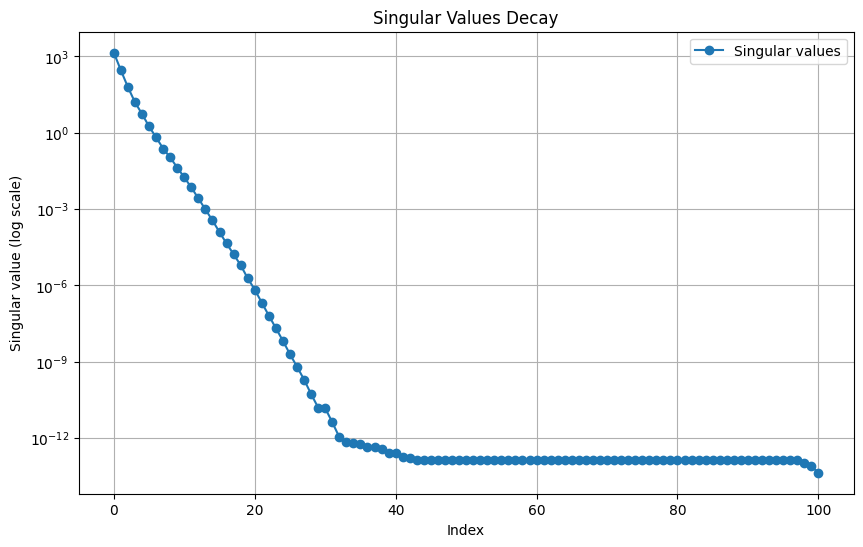

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameter ranges and generate a grid
deltas = np.linspace(0.05, 0.1, 5)
Ds = np.linspace(1, 5, 5)
ds = np.linspace(0.02, 0.08, 5)

# Initialize snapshots as None
snapshots = None

# Iterate over all combinations of parameters
for delta in deltas:
    for D in Ds:
        for d in ds:
            # Solve the model for the current set of parameters
            u = FOMsolver(delta, D, d)

            # Assemble the snapshot matrix
            if snapshots is None:
                snapshots = u  # Initialize with the first result
            else:
                snapshots = np.hstack((snapshots, u))  # Stack horizontally with the existing snapshots

# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(snapshots, full_matrices=False)

# Plot the singular values' decay
plt.figure(figsize=(10, 6))
plt.plot(S, 'o-', label='Singular values')
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular value (log scale)')
plt.title('Singular Values Decay')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
snapshots.shape


(101, 52488)

In [46]:
u.shape

(101, 6561)

In [40]:
np.save('snapshots.npy', snapshots)
np.save('params.npy', params)
snapshots.shape

(101, 820125)

In [42]:
snapshots.shape

(101, 820125)

In [52]:
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility.

    Args:
        seed (int): Seed to use for random number generators. Default is 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



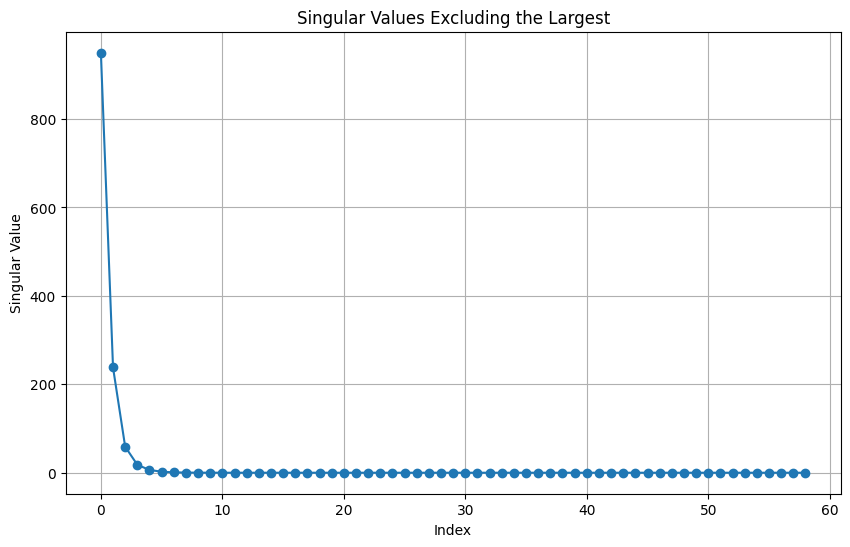

In [73]:
#@title Singular Value Study and Reduced Matrix assmembly
from scipy.linalg import svd
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

snapshots = np.load('/content/snapshots.npy')

snapshots = np.array(snapshots)
U, s, Vt = svd(snapshots, full_matrices=False)


# Now you can apply SVD or any other analysis you wish to this giant matrix
from scipy.linalg import svd
U, s, Vt = svd(snapshots, full_matrices=False)

energy = np.cumsum(s**2) / np.sum(s**2)

n_modes = 20

V = U[:, :n_modes]

import matplotlib.pyplot as plt
import numpy as np

# Assuming 's' contains your singular values from the SVD
singular_values = s[1:60]  # Exclude the largest singular value

# Plotting the remaining singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o')
plt.title('Singular Values Excluding the Largest')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()




mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

from scipy.sparse import csr_matrix

# Assuming we have a function to assemble FOM matrices





The script also gives access to a collection of $N$ FOM simulations, which can be readily downloaded and inspected. The data were sampled by picking random values of $\boldsymbol{\mu}$ uniformly in the parameter space $[80, 120]^3\times [1.5, 5] \times [-3.5, -1.5].$

**Note**

NN based ROMs become even more efficient when multiple calls are required (1000 calls are not 1000 times more expensive than a single call)! This is thanks to the elevanted efficiency of matrix-matrix multiplication.

In [74]:
from dlroms import*
mu = dv.tensor(params)
u = dv.tensor(u)
V = dv.tensor(V)

In [66]:
V.shape


torch.Size([101, 20])

In [67]:
u.shape

torch.Size([101, 6561])

In [75]:
ntrain = 70
u = u.T
uproj = u @ V @ V.T
avg_proj_error = mre(euclidean)(u[ntrain:], uproj[ntrain:])
print("Average projection error: %s." % num2p(avg_proj_error))

Average projection error: 0.00%.


In [76]:
c = u @ V
c.shape

torch.Size([6561, 20])

In [77]:
# Ex. 1.4.
# Note: phi should go from mu (5-dimensional) to c (n-dimensional)

phi = Dense(mu.shape[1], 10) + Dense(10, 10) + Dense(10, n, activation = None)
model = DFNN(phi)
model.He()
model.train(mu, c, ntrain = ntrain, epochs = 50, loss = mse(euclidean))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

<mark>**Exercise 2**</mark></br>
Let $T_2 = 90,\; T_3 = 115,\;f = 10^3,\;\alpha=10^{-3}.$ Which value of $T_1\in[80, 120]$ minimizes the variability of the temperature across the rod? Exploit the ROM to answer the question.
</br></br>
*Note:* here, we define the latter as

$$\text{Var}(\mathbf{u}):=\frac{1}{N_h}\sum_{j=1}^{N_h}|\mathrm{u}_j-\overline{\mathrm{u}}|^2,$$

where $\overline{\mathrm{u}}:=\frac{1}{N_h}\sum_{j=1}^{N_h}\mathrm{u}_j$.

In [ ]:
T1min = Ts[variances.argmin()]
print("Variance is minimized for T1 = %.2f." % T1min)

Variance is minimized for T1 = 94.88.
